# Preparation
Downloading Sentinel 2 data on Gold Coast waterways area

## Import Library

In [1]:
import cubo
import spyndex
import xarray as xr
from dask.distributed import Client
from dask.distributed import LocalCluster
import dask.dataframe as dd
import rioxarray
import geopandas as gpd
import pandas as pd
import gc
import planetary_computer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import os
from pathlib import Path
import numpy as np
import rioxarray as rxr
from glob import glob
import datetime
from shapely.geometry import Polygon
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import folium
from dask.diagnostics import ProgressBar

In [2]:
ProgressBar().register()

## Create cluster

In [3]:
cluster = LocalCluster(
    n_workers=2,
    processes=True,
    threads_per_worker=2,
    memory_limit="4GB",
)
client = Client(cluster)
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")
client

/proxy/8787/status


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50640,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:50647,Total threads: 2
Dashboard: http://127.0.0.1:50650/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:50643,


## Define function
Function for filtering and downloading data

In [4]:
def check_and_create_folder(folder_path: Path) -> None:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)


def create_cluster_blank_band(cluster_da: xr.DataArray, band_names: list[str] | str):
    cluster_da_mask = cluster_da
    # LOG.info("Creating cluster blank band")
    if type(band_names) is not list:
        band_list = [band_names]
    else:
        band_list = band_names

    for band_name in band_list:
        mask_aggs = []
        for x in cluster_da_mask:
            mask_aggs.append(xr.ones_like(x.sel(band="B02")))

        mask = xr.concat(mask_aggs, dim="time")

        mask.name = band_name
        cluster_da_mask = xr.concat(
            [
                cluster_da_mask,
                mask.expand_dims(band=[band_name]),
            ],
            dim="band",
        )
    return cluster_da_mask

## Query data

In [5]:
start_date = "2023-07-01"
end_date = "2025-10-12"

Query cluster 1

In [6]:
latitude1, longitude1 = -28.07, 153.43627

da_cluster1 = cubo.create(
    lat=latitude1,  # Central latitude of the cube
    lon=longitude1,  # Central longitude of the cube
    collection="sentinel-2-l2a",  # Name of the STAC collection
    bands=["B02", "B03", "B04", "B08", "SCL"],  # Bands to retrieve
    start_date=start_date,  # Start date of the cube
    end_date=end_date,  # End date of the cube
    edge_size=1024,  # Edge size of the cube (px)
    resolution=10,  # Pixel size of the cube (m)
    query={"eo:cloud_cover": {"lt": 10}},  # 10% cloud treshold,
)
# duplicates = da.time.to_pandas()[da.time.to_pandas().duplicated()]
# duplicates
da_cluster1 = da_cluster1.drop_duplicates(dim="time", keep="last")
da_cluster1

<xarray.DataArray 'sentinel-2-l2a' (time: 60, band: 5, y: 1024, x: 1024)> Size: 3GB
dask.array<getitem, shape=(60, 5, 1024, 1024), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 480B 2023-...
    id                                       (time) <U54 13kB 'S2B_MSIL2A_202...
  * band                                     (band) <U3 60B 'B02' ... 'SCL'
  * x                                        (x) float64 8kB 5.378e+05 ... 5....
  * y                                        (y) float64 8kB 6.9e+06 ... 6.89...
    proj:code                                <U10 40B 'EPSG:32756'
    ...                                       ...
    gsd                                      (band) float64 40B 10.0 ... 20.0
    common_name                              (band) object 40B 'blue' ... None
    center_wavelength                        (band) object 40B 0.49 ... None
    full_width_half_max                      (band) object 40B 0.098 ... None
    epsg                                     int64 8B 32756
    cubo:distance_from_center                (y, x) float64 8MB 7.242e+03 ......
Attributes:
    collection:           sentinel-2-l2a
    stac:                 https://planetarycomputer.microsoft.com/api/stac/v1
    epsg:                 32756
    resolution:           10
    edge_size:            1024
    edge_size_m:          10240
    central_lat:          -28.07
    central_lon:          153.43627
    central_y:            6894966.534324411
    central_x:            542867.6484120359
    time_coverage_start:  2023-07-01
    time_coverage_end:    2025-10-12

Show RGB data of latest date

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.112].


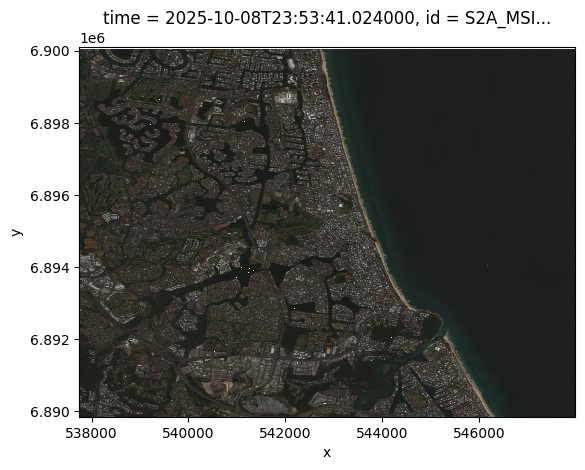

In [7]:
(da_cluster1.sel(band=["B04", "B03", "B02"])[-1] / 10000).plot.imshow()

Query cluster 2

In [8]:
latitude2, longitude2 = -27.97, 153.43627

da_cluster2 = cubo.create(
    lat=latitude2,  # Central latitude of the cube
    lon=longitude2,  # Central longitude of the cube
    collection="sentinel-2-l2a",  # Name of the STAC collection
    bands=["B02", "B03", "B04", "B08", "SCL"],  # Bands to retrieve
    start_date=start_date,  # Start date of the cube
    end_date=end_date,  # End date of the cube
    edge_size=1024,  # Edge size of the cube (px)
    resolution=10,  # Pixel size of the cube (m)
    query={"eo:cloud_cover": {"lt": 10}},  # 10% cloud treshold,
)
# duplicates = da.time.to_pandas()[da.time.to_pandas().duplicated()]
# duplicates
da_cluster2 = da_cluster2.drop_duplicates(dim="time", keep="last")
da_cluster2

<xarray.DataArray 'sentinel-2-l2a' (time: 71, band: 5, y: 1024, x: 1024)> Size: 3GB
dask.array<getitem, shape=(71, 5, 1024, 1024), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/45)
  * time                                     (time) datetime64[ns] 568B 2023-...
    id                                       (time) <U54 15kB 'S2B_MSIL2A_202...
  * band                                     (band) <U3 60B 'B02' ... 'SCL'
  * x                                        (x) float64 8kB 5.378e+05 ... 5....
  * y                                        (y) float64 8kB 6.911e+06 ... 6....
    proj:code                                <U10 40B 'EPSG:32756'
    ...                                       ...
    gsd                                      (band) float64 40B 10.0 ... 20.0
    common_name                              (band) object 40B 'blue' ... None
    center_wavelength                        (band) object 40B 0.49 ... None
    full_width_half_max                      (band) object 40B 0.098 ... None
    epsg                                     int64 8B 32756
    cubo:distance_from_center                (y, x) float64 8MB 7.236e+03 ......
Attributes:
    collection:           sentinel-2-l2a
    stac:                 https://planetarycomputer.microsoft.com/api/stac/v1
    epsg:                 32756
    resolution:           10
    edge_size:            1024
    edge_size_m:          10240
    central_lat:          -27.97
    central_lon:          153.43627
    central_y:            6906044.259576842
    central_x:            542907.274941191
    time_coverage_start:  2023-07-01
    time_coverage_end:    2025-10-12

Show RGB data of latest date

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.3152].


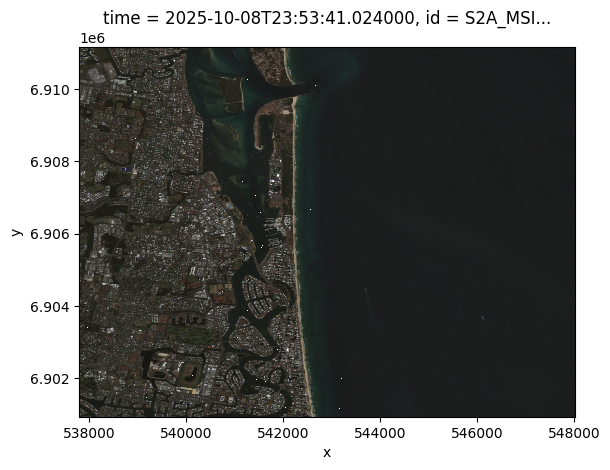

In [9]:
(da_cluster2.sel(band=["B04", "B03", "B02"])[-1] / 10000).plot.imshow()

Load SWQ data

In [10]:
sentinel_water_sensor_file = "./sentinel_water_quality.geojson"
sentinel_water = gpd.read_file(sentinel_water_sensor_file)
sentinel_water["date"] = pd.to_datetime(sentinel_water["date"])
sentinel_water.head()

,No,sensor,date,time,turbidity,geometry
0,1,DUC0001,2023-10-11,11.37.00,1.9,POINT (153.42031 -28.06907)
1,2,DUC0001,2024-01-25,13.01.00,6.9,POINT (153.42031 -28.06907)
2,3,DUC0001,2024-05-07,11.44.00,2.9,POINT (153.42031 -28.06907)
3,4,DUC0001,2024-07-19,10.39.00,1.2,POINT (153.42031 -28.06907)
4,5,DUC0001,2024-10-30,10.52.00,1.8,POINT (153.42031 -28.06907)


Create BBOX to show on map

In [11]:
temp_data1 = da_cluster1[-1].sel(band=["B04", "B03", "B02"])
temp_data1 = temp_data1.rio.write_crs(32756)
temp_data1 = temp_data1.rio.reproject(4326)
bbox = temp_data1.rio.bounds()
bbox1 = [(bbox[1], bbox[0]), (bbox[3], bbox[2])]

In [12]:
temp_data2 = da_cluster2[-1].sel(band=["B04", "B03", "B02"])
temp_data2 = temp_data2.rio.write_crs(32756)
temp_data2 = temp_data2.rio.reproject(4326)
bbox = temp_data2.rio.bounds()
bbox2 = [(bbox[1], bbox[0]), (bbox[3], bbox[2])]

Show BBOX of the AoI

In [13]:
m = folium.Map(location=[latitude2, longitude2], zoom_start=10)

folium.Rectangle(
    bounds=bbox1,
    color="blue",
    weight=2,
    fill=True,
    fill_color="lightblue",
    fill_opacity=0.4,
).add_to(m)

folium.Rectangle(
    bounds=bbox2,
    color="blue",
    weight=2,
    fill=True,
    fill_color="lightblue",
    fill_opacity=0.4,
).add_to(m)

i = 0
geo_df_list = [[point.xy[0][0], point.xy[1][0]] for point in sentinel_water.geometry]
for coordinates in geo_df_list:
    folium.Marker(
        location=[coordinates[1], coordinates[0]],
        popup="Sensor: " + sentinel_water["sensor"][i],
        icon=folium.Icon(color="blue"),
    ).add_to(m)
    i = i + 1

m

In [14]:
lats = temp_data1["y"].values
lons = temp_data1["x"].values
polygon1 = Polygon(
    [
        (lons.min(), lats.min()),
        (lons.min(), lats.max()),
        (lons.max(), lats.max()),
        (lons.max(), lats.min()),
    ]
)
gpd.GeoSeries([polygon1]).set_crs(32756).to_file("area_of_interest_cluster1.geojson")

lats = temp_data2["y"].values
lons = temp_data2["x"].values
polygon2 = Polygon(
    [
        (lons.min(), lats.min()),
        (lons.min(), lats.max()),
        (lons.max(), lats.max()),
        (lons.max(), lats.min()),
    ]
)
gpd.GeoSeries([polygon2]).set_crs(32756).to_file("area_of_interest_cluster2.geojson")

Create blank band for index, divide RGB by 10000

In [15]:
def prepare_da(da):
    da_test = da.copy() / 10000
    da_test.loc[dict(band="SCL")] = da_test.sel(band="SCL") * 10000
    da_test = create_cluster_blank_band(da_test, ["NDTI"])
    da_test = create_cluster_blank_band(da_test, ["NDWI"])
    da_test = create_cluster_blank_band(da_test, ["turbidity"])
    da_test = da_test.reset_coords("cubo:distance_from_center", drop=True)
    da_test = da_test.reset_coords("full_width_half_max", drop=True)
    return da_test

In [16]:
da_cluster1 = prepare_da(da_cluster1)
da_cluster1

/var/folders/tj/2681nd5j10b0nf0d9jlfsgrr0000gn/T/ipykernel_36551/4202206065.py:19: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  mask = xr.concat(mask_aggs, dim="time")
/var/folders/tj/2681nd5j10b0nf0d9jlfsgrr0000gn/T/ipykernel_36551/4202206065.py:19: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  mask = xr.concat

<xarray.DataArray 'sentinel-2-l2a' (time: 60, band: 8, y: 1024, x: 1024)> Size: 4GB
dask.array<concatenate, shape=(60, 8, 1024, 1024), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/42)
  * time                                     (time) datetime64[ns] 480B 2023-...
    id                                       (time) <U54 13kB 'S2B_MSIL2A_202...
  * band                                     (band) object 64B 'B02' ... 'tur...
  * x                                        (x) float64 8kB 5.378e+05 ... 5....
  * y                                        (y) float64 8kB 6.9e+06 ... 6.89...
    proj:code                                <U10 40B 'EPSG:32756'
    ...                                       ...
    s2:water_percentage                      (time) float64 480B 50.28 ... 48.08
    title                                    (band) <U29 928B 'Band 2 - Blue ...
    gsd                                      (band) float64 64B 10.0 ... 10.0
    common_name                              (band) object 64B 'blue' ... 'blue'
    center_wavelength                        (band) object 64B 0.49 ... 0.49
    epsg                                     int64 8B 32756

In [17]:
da_cluster2 = prepare_da(da_cluster2)
da_cluster2

/var/folders/tj/2681nd5j10b0nf0d9jlfsgrr0000gn/T/ipykernel_36551/4202206065.py:19: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  mask = xr.concat(mask_aggs, dim="time")
/var/folders/tj/2681nd5j10b0nf0d9jlfsgrr0000gn/T/ipykernel_36551/4202206065.py:19: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  mask = xr.concat

<xarray.DataArray 'sentinel-2-l2a' (time: 71, band: 8, y: 1024, x: 1024)> Size: 5GB
dask.array<concatenate, shape=(71, 8, 1024, 1024), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/43)
  * time                                     (time) datetime64[ns] 568B 2023-...
    id                                       (time) <U54 15kB 'S2B_MSIL2A_202...
  * band                                     (band) object 64B 'B02' ... 'tur...
  * x                                        (x) float64 8kB 5.378e+05 ... 5....
  * y                                        (y) float64 8kB 6.911e+06 ... 6....
    proj:code                                <U10 40B 'EPSG:32756'
    ...                                       ...
    proj:bbox                                object 8B {6890200.0, 609780.0, ...
    title                                    (band) <U29 928B 'Band 2 - Blue ...
    gsd                                      (band) float64 64B 10.0 ... 10.0
    common_name                              (band) object 64B 'blue' ... 'blue'
    center_wavelength                        (band) object 64B 0.49 ... 0.49
    epsg                                     int64 8B 32756

# Input field data from SWQ sensor

## Filter sensor inside Area of Interest

In [18]:
def filter_within(field_data, polygon):
    filtered_data = field_data[field_data.within(polygon)]
    filtered_data = filtered_data.to_crs(32756)
    return filtered_data

In [19]:
sentinel_water_cluster1 = filter_within(sentinel_water, polygon1)
print(f"Total field data inside AoI: {len(sentinel_water_cluster1)}")
sentinel_water_cluster1.head()

Total field data inside AoI: 40


,No,sensor,date,time,turbidity,geometry
0,1,DUC0001,2023-10-11,11.37.00,1.9,POINT (541299.454 6895075.477)
1,2,DUC0001,2024-01-25,13.01.00,6.9,POINT (541299.454 6895075.477)
2,3,DUC0001,2024-05-07,11.44.00,2.9,POINT (541299.454 6895075.477)
3,4,DUC0001,2024-07-19,10.39.00,1.2,POINT (541299.454 6895075.477)
4,5,DUC0001,2024-10-30,10.52.00,1.8,POINT (541299.454 6895075.477)


In [20]:
sentinel_water_cluster2 = filter_within(sentinel_water, polygon2)
print(f"Total field data inside AoI: {len(sentinel_water_cluster2)}")
sentinel_water_cluster2.head()

Total field data inside AoI: 24


,No,sensor,date,time,turbidity,geometry
40,41,BWC0001,2023-10-11,10.07.00,1.70,POINT (540521.17 6902786.806)
41,42,BWC0001,2024-01-25,11.10.00,4.10,POINT (540521.17 6902786.806)
42,43,BWC0001,2024-05-07,10.33.00,2.20,POINT (540521.17 6902786.806)
43,44,BWC0001,2025-07-19,09.32.00,0.81,POINT (540521.17 6902786.806)
44,45,BWC0001,2024-10-30,09.44.00,1.80,POINT (540521.17 6902786.806)


## Input turbidity in data at the nearest date

In [21]:
def input_field_data(da, field_data, date_dif: int = 5):
    date_list = []
    date_dict = {}
    da_test = da.copy()
    i = 0
    for index, row in field_data.iterrows():
        selected_data = da_test.sel(time=row["date"], method="nearest")
        date_difference = (row["date"] - selected_data.time.to_pandas()).days
        if date_difference >= date_dif:
            i = i + 1
        else:
            if selected_data.time.to_pandas() not in date_list:
                date_list.append(selected_data.time.to_pandas())
                date_dict[selected_data.time.to_pandas()] = []

            sel_p = selected_data.sel(
                x=row.geometry.x, y=row.geometry.y, method="nearest"
            )
            date_dict[selected_data.time.to_pandas()].append(
                {
                    "sensor": row.sensor,
                    "turbidity": row.turbidity,
                    "location": sel_p,
                }
            )
    for index, row in date_dict.items():
        mask = xr.zeros_like(da_test.sel(band="B04")[-1])
        for turbid in row:
            selected_data = da_test.sel(time=index)
            mask.loc[dict(x=turbid["location"].x, y=turbid["location"].y)] = turbid[
                "turbidity"
            ]
            # mask.loc[dict(x=turbid["location"].x, y=turbid["location"].y)] = 2
            selected_data.loc[dict(band="turbidity")] = mask.values
            selected_data.loc[dict(band="turbidity")] = selected_data.sel(
                band="turbidity"
            ).where(selected_data.sel(band="turbidity") > 0)
            da_test.loc[dict(time=selected_data.time)] = selected_data

    print(
        f"{i} data with more than 5 days difference, compared to {len(field_data)} total insitu data"
    )
    print(
        f"Loss of {(100 - ((len(field_data) - i) / len(field_data))* 100)}% in-situ data"
    )

    return da_test

In [22]:
da_cluster1 = input_field_data(da_cluster1, sentinel_water_cluster1, 5)
da_cluster1

14 data with more than 5 days difference, compared to 40 total insitu data
Loss of 35.0% in-situ data


<xarray.DataArray 'sentinel-2-l2a' (time: 60, band: 8, y: 1024, x: 1024)> Size: 4GB
dask.array<setitem, shape=(60, 8, 1024, 1024), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/42)
  * time                                     (time) datetime64[ns] 480B 2023-...
    id                                       (time) <U54 13kB 'S2B_MSIL2A_202...
  * band                                     (band) object 64B 'B02' ... 'tur...
  * x                                        (x) float64 8kB 5.378e+05 ... 5....
  * y                                        (y) float64 8kB 6.9e+06 ... 6.89...
    proj:code                                <U10 40B 'EPSG:32756'
    ...                                       ...
    s2:water_percentage                      (time) float64 480B 50.28 ... 48.08
    title                                    (band) <U29 928B 'Band 2 - Blue ...
    gsd                                      (band) float64 64B 10.0 ... 10.0
    common_name                              (band) object 64B 'blue' ... 'blue'
    center_wavelength                        (band) object 64B 0.49 ... 0.49
    epsg                                     int64 8B 32756

In [23]:
da_cluster2 = input_field_data(da_cluster2, sentinel_water_cluster2, 5)
da_cluster2

7 data with more than 5 days difference, compared to 24 total insitu data
Loss of 29.166666666666657% in-situ data


<xarray.DataArray 'sentinel-2-l2a' (time: 71, band: 8, y: 1024, x: 1024)> Size: 5GB
dask.array<setitem, shape=(71, 8, 1024, 1024), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/43)
  * time                                     (time) datetime64[ns] 568B 2023-...
    id                                       (time) <U54 15kB 'S2B_MSIL2A_202...
  * band                                     (band) object 64B 'B02' ... 'tur...
  * x                                        (x) float64 8kB 5.378e+05 ... 5....
  * y                                        (y) float64 8kB 6.911e+06 ... 6....
    proj:code                                <U10 40B 'EPSG:32756'
    ...                                       ...
    proj:bbox                                object 8B {6890200.0, 609780.0, ...
    title                                    (band) <U29 928B 'Band 2 - Blue ...
    gsd                                      (band) float64 64B 10.0 ... 10.0
    common_name                              (band) object 64B 'blue' ... 'blue'
    center_wavelength                        (band) object 64B 0.49 ... 0.49
    epsg                                     int64 8B 32756

# Cloud mask

## Create cloud mask
Use SCL band as mask

In [24]:
def cloud_mask(da):
    da_test = da.copy()
    SCL = da.sel(band="SCL")
    SCL = SCL.where(~SCL.isin([0, 1, 2, 3, 7, 8, 9, 10, 11]))
    SCL = xr.where(SCL > 0, True, False)
    da_test.loc[dict(band="B02")] = da_test.sel(band="B02").where(SCL)
    da_test.loc[dict(band="B03")] = da_test.sel(band="B03").where(SCL)
    da_test.loc[dict(band="B04")] = da_test.sel(band="B04").where(SCL)
    da_test.loc[dict(band="B08")] = da_test.sel(band="B08").where(SCL)
    da_test.loc[dict(band="NDTI")] = da_test.sel(band="NDTI").where(SCL)
    da_test.loc[dict(band="NDWI")] = da_test.sel(band="NDWI").where(SCL)
    da_test.loc[dict(band="turbidity")] = da_test.sel(band="turbidity").where(SCL)
    return da_test

In [25]:
da_cluster1 = cloud_mask(da_cluster1)
da_cluster1

<xarray.DataArray 'sentinel-2-l2a' (time: 60, band: 8, y: 1024, x: 1024)> Size: 4GB
dask.array<setitem, shape=(60, 8, 1024, 1024), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/42)
  * time                                     (time) datetime64[ns] 480B 2023-...
    id                                       (time) <U54 13kB 'S2B_MSIL2A_202...
  * band                                     (band) object 64B 'B02' ... 'tur...
  * x                                        (x) float64 8kB 5.378e+05 ... 5....
  * y                                        (y) float64 8kB 6.9e+06 ... 6.89...
    proj:code                                <U10 40B 'EPSG:32756'
    ...                                       ...
    s2:water_percentage                      (time) float64 480B 50.28 ... 48.08
    title                                    (band) <U29 928B 'Band 2 - Blue ...
    gsd                                      (band) float64 64B 10.0 ... 10.0
    common_name                              (band) object 64B 'blue' ... 'blue'
    center_wavelength                        (band) object 64B 0.49 ... 0.49
    epsg                                     int64 8B 32756

In [26]:
da_cluster2 = cloud_mask(da_cluster2)
da_cluster2

<xarray.DataArray 'sentinel-2-l2a' (time: 71, band: 8, y: 1024, x: 1024)> Size: 5GB
dask.array<setitem, shape=(71, 8, 1024, 1024), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/43)
  * time                                     (time) datetime64[ns] 568B 2023-...
    id                                       (time) <U54 15kB 'S2B_MSIL2A_202...
  * band                                     (band) object 64B 'B02' ... 'tur...
  * x                                        (x) float64 8kB 5.378e+05 ... 5....
  * y                                        (y) float64 8kB 6.911e+06 ... 6....
    proj:code                                <U10 40B 'EPSG:32756'
    ...                                       ...
    proj:bbox                                object 8B {6890200.0, 609780.0, ...
    title                                    (band) <U29 928B 'Band 2 - Blue ...
    gsd                                      (band) float64 64B 10.0 ... 10.0
    common_name                              (band) object 64B 'blue' ... 'blue'
    center_wavelength                        (band) object 64B 0.49 ... 0.49
    epsg                                     int64 8B 32756

Cloud mask preview

In [ ]:
SCL = da_cluster1.sel(band="SCL")
SCL = SCL.where(~SCL.isin([0, 1, 2, 3, 7, 8, 9, 10, 11]))
SCL = xr.where(SCL > 0, True, False)
SCL[-1].plot.imshow()

# Calculate NDVI and NDWI with Spyndex

In [28]:
def calculate_index(da):
    da_test = da.copy()
    idx = spyndex.computeIndex(
        index=["NDTI", "NDWI"],
        params={
            "N": da_test.sel(band="B08"),
            "R": da_test.sel(band="B04"),
            "G": da_test.sel(band="B03"),
        },
    )
    da_test.loc[dict(band="NDTI")] = idx.sel(index="NDTI")
    da_test.loc[dict(band="NDWI")] = idx.sel(index="NDWI")
    return da_test

In [29]:
da_cluster1 = calculate_index(da_cluster1)
da_cluster1

<xarray.DataArray 'sentinel-2-l2a' (time: 60, band: 8, y: 1024, x: 1024)> Size: 4GB
dask.array<setitem, shape=(60, 8, 1024, 1024), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/42)
  * time                                     (time) datetime64[ns] 480B 2023-...
    id                                       (time) <U54 13kB 'S2B_MSIL2A_202...
  * band                                     (band) object 64B 'B02' ... 'tur...
  * x                                        (x) float64 8kB 5.378e+05 ... 5....
  * y                                        (y) float64 8kB 6.9e+06 ... 6.89...
    proj:code                                <U10 40B 'EPSG:32756'
    ...                                       ...
    s2:water_percentage                      (time) float64 480B 50.28 ... 48.08
    title                                    (band) <U29 928B 'Band 2 - Blue ...
    gsd                                      (band) float64 64B 10.0 ... 10.0
    common_name                              (band) object 64B 'blue' ... 'blue'
    center_wavelength                        (band) object 64B 0.49 ... 0.49
    epsg                                     int64 8B 32756

In [30]:
da_cluster2 = calculate_index(da_cluster2)
da_cluster2

<xarray.DataArray 'sentinel-2-l2a' (time: 71, band: 8, y: 1024, x: 1024)> Size: 5GB
dask.array<setitem, shape=(71, 8, 1024, 1024), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/43)
  * time                                     (time) datetime64[ns] 568B 2023-...
    id                                       (time) <U54 15kB 'S2B_MSIL2A_202...
  * band                                     (band) object 64B 'B02' ... 'tur...
  * x                                        (x) float64 8kB 5.378e+05 ... 5....
  * y                                        (y) float64 8kB 6.911e+06 ... 6....
    proj:code                                <U10 40B 'EPSG:32756'
    ...                                       ...
    proj:bbox                                object 8B {6890200.0, 609780.0, ...
    title                                    (band) <U29 928B 'Band 2 - Blue ...
    gsd                                      (band) float64 64B 10.0 ... 10.0
    common_name                              (band) object 64B 'blue' ... 'blue'
    center_wavelength                        (band) object 64B 0.49 ... 0.49
    epsg                                     int64 8B 32756

In [ ]:
da_cluster1.sel(band="NDTI")[-1].plot.imshow(robust=True, cmap="viridis")

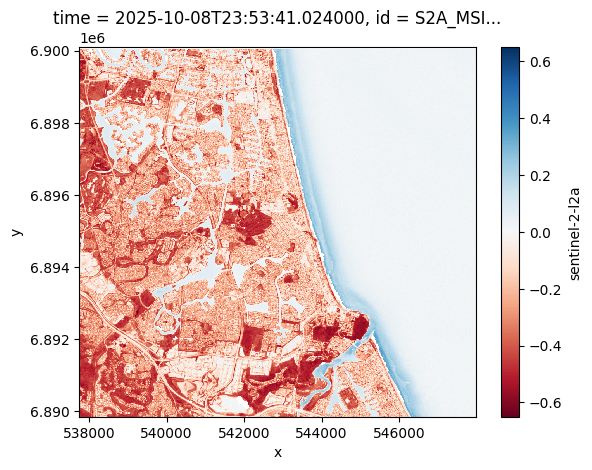

In [32]:
da_cluster1.sel(band="NDWI")[-1].plot.imshow(cmap="RdBu")

## Apply Threshold

In [33]:
landmask_threshold = -0.05


def apply_ndwi_threshold(da, landmask_threshold: float = -0.05):
    da_test = da.copy()
    da_test.loc[dict(band="NDTI")] = da_test.sel(band="NDTI").where(
        da_test.sel(band="NDWI") > landmask_threshold
    )
    da_test.loc[dict(band="NDWI")] = da_test.sel(band="NDWI").where(
        da_test.sel(band="NDWI") > landmask_threshold
    )
    return da_test

In [34]:
da_cluster1 = apply_ndwi_threshold(da_cluster1)
da_cluster1

<xarray.DataArray 'sentinel-2-l2a' (time: 60, band: 8, y: 1024, x: 1024)> Size: 4GB
dask.array<setitem, shape=(60, 8, 1024, 1024), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/42)
  * time                                     (time) datetime64[ns] 480B 2023-...
    id                                       (time) <U54 13kB 'S2B_MSIL2A_202...
  * band                                     (band) object 64B 'B02' ... 'tur...
  * x                                        (x) float64 8kB 5.378e+05 ... 5....
  * y                                        (y) float64 8kB 6.9e+06 ... 6.89...
    proj:code                                <U10 40B 'EPSG:32756'
    ...                                       ...
    s2:water_percentage                      (time) float64 480B 50.28 ... 48.08
    title                                    (band) <U29 928B 'Band 2 - Blue ...
    gsd                                      (band) float64 64B 10.0 ... 10.0
    common_name                              (band) object 64B 'blue' ... 'blue'
    center_wavelength                        (band) object 64B 0.49 ... 0.49
    epsg                                     int64 8B 32756

In [35]:
da_cluster2 = apply_ndwi_threshold(da_cluster2)
da_cluster2

<xarray.DataArray 'sentinel-2-l2a' (time: 71, band: 8, y: 1024, x: 1024)> Size: 5GB
dask.array<setitem, shape=(71, 8, 1024, 1024), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/43)
  * time                                     (time) datetime64[ns] 568B 2023-...
    id                                       (time) <U54 15kB 'S2B_MSIL2A_202...
  * band                                     (band) object 64B 'B02' ... 'tur...
  * x                                        (x) float64 8kB 5.378e+05 ... 5....
  * y                                        (y) float64 8kB 6.911e+06 ... 6....
    proj:code                                <U10 40B 'EPSG:32756'
    ...                                       ...
    proj:bbox                                object 8B {6890200.0, 609780.0, ...
    title                                    (band) <U29 928B 'Band 2 - Blue ...
    gsd                                      (band) float64 64B 10.0 ... 10.0
    common_name                              (band) object 64B 'blue' ... 'blue'
    center_wavelength                        (band) object 64B 0.49 ... 0.49
    epsg                                     int64 8B 32756

In [ ]:
da_cluster1.sel(band=["B04", "B03", "B02"])[0].plot.imshow()

In [ ]:
da_cluster2.sel(band=["B04", "B03", "B02"])[0].plot.imshow()

# Write data

In [ ]:
download_location = Path("./data")
check_and_create_folder(download_location / "cluster1")
for data in da_cluster1:
    file_location = download_location / "cluster1" / f"{data.id.values}.tif"
    if not os.path.isfile(file_location):
        # data = data.reset_coords("cubo:distance_from_center", drop=True)
        # data = data.reset_coords("proj:bbox", drop=True)
        data = data.rio.write_crs(32756)
        data.rio.to_raster(str(file_location), driver="GTiff")

In [39]:
del da_cluster1
gc.collect()

11444

In [ ]:
download_location = Path("./data")
check_and_create_folder(download_location / "cluster2")
for data in da_cluster2:
    file_location = download_location / "cluster2" / f"{data.id.values}.tif"
    if not os.path.isfile(file_location):
        # data = data.reset_coords("cubo:distance_from_center", drop=True)
        # data = data.reset_coords("proj:bbox", drop=True)
        data = data.rio.write_crs(32756)
        data.rio.to_raster(str(file_location), driver="GTiff")

In [41]:
del da_cluster2
gc.collect()

13038